# Comparative Analysis of Economic Performance on unseen Data

# config and imports

In [14]:
from narwhals import Datetime
from torch.cuda.nvtx import mark
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Pfad zum Projekt-Root hinzufügen, um das Package 'src' zu finden
# Annahme: Dieses Notebook liegt in src/notebooks/
import sys
from pathlib import Path

import joblib
import pandas as pd
from tqdm import tqdm
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# custom imports
PROJECT_ROOT = Path(__file__).resolve().parent.parent.parent if "__file__" in locals() else Path("../../..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.d_eval.evaluation.loader import load_model, load_test_data_v2
from src.d_eval.evaluation.style import apply_shap_style, get_model_style, save_plot

apply_shap_style()

In [16]:
# paths
DATA_DIR = "/Users/robin/PycharmProjects/Masterarbeit_Public/data/parquet/features/asinh1-reg"
VAL_SET_PATH = DATA_DIR + "/splits/test_purged.parquet"
SCALER_PATH = DATA_DIR + "/scaler/scaler.joblib"
MODELS_DIR = "/Users/robin/PycharmProjects/Masterarbeit_Public/models"

# figures
FIGURES_DIR = "figures/sparsity"

# target
TARGET_COL = "label_5min"
THINNING_FREQ_MIN = 5

# data
TTD_MINUTES_MIN = 30
TTD_MINUTES_MAX = 300

# models
MODEL_PATHS = {
    "CatBoost": MODELS_DIR + "/" + "CatBoostGPU.joblib",
    "MLP": MODELS_DIR + "/" + "MLP.joblib",
    "RF": MODELS_DIR + "/" + "RandomForest.joblib",
    "EBM": MODELS_DIR + "/" + "ebm.joblib",
    "Lasso": MODELS_DIR + "/" + "Lasso_LargeScale.joblib",
}

BEST_THRESHOLDS = {
    'MLP': 2.0,
    'CatBoost': 3.0,
    'Lasso': 2.0,
    "EBM": 3.0,
    "RF": 3.5,
}

# load data & models

In [17]:
# load models
models = {}
for model_name, model_path in tqdm(MODEL_PATHS.items(), desc="Modelle laden"):
    model = load_model(model_path)
    models[model_name] = model

Modelle laden:   0%|          | 0/5 [00:00<?, ?it/s]/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Tr

Fixing missing 'multi_class' attribute for MLPRegressor...


In [18]:
# load data and prepare

X_test_scaled, y_test_scaled = load_test_data_v2(
    VAL_SET_PATH,
    target_col=TARGET_COL,
    keep_id_cols=True,
    sample_minutes=THINNING_FREQ_MIN,
    min_ttd_minutes=TTD_MINUTES_MIN, max_ttd_minutes=TTD_MINUTES_MAX

)

# meta col names
product_keys_col = "delivery_start"
snapshot_times_col = "snapshot_times"
ttd_min_col = "ttd_min_to_delivery"

# extract product keys for later use
df_signals = pd.DataFrame({
    product_keys_col: X_test_scaled['delivery_start'],
    snapshot_times_col: X_test_scaled['snapshot_times']
}, index=X_test_scaled.index)

df_signals[ttd_min_col] = (df_signals[product_keys_col] - df_signals[
    snapshot_times_col]).dt.total_seconds() / 60

print("-" * 30)
print(f"Anzahl Test-Samples (nach Downsampling): {len(y_test_scaled):,}")

# drop id cols from features
X_test_scaled = X_test_scaled.drop(columns=['delivery_start', "snapshot_times"])

Memory usage of dataframe is 747.76 MB
Memory usage after optimization is: 724.87 MB
Decreased by 3.1%
Downsampling (Relativ 5min): Von 2,000,203 auf 71,628 Zeilen reduziert.
Clipping TTD window to range: 30 - 300 minutes
Rows to be clipped based on TTD min: 6565 / 71628 (9.17%)
Rows to be clipped based on TTD max: 0 / 71628 (0.00%)
Data shape after clipping TTD window: (65063, 80)
------------------------------
Anzahl Test-Samples (nach Downsampling): 65,063


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


def get_permutation_importance_dict(models_dict, X_val, y_val, n_repeats=5, random_state=42):
    """
    Berechnet die Permutation Importance für eine Liste von Modellen.
    models_dict: {'ModelName': model_object}
    """
    importance_results = {}

    for name, model in models_dict.items():
        print(f"Calculating Permutation Importance for {name}...")
        # Wir messen die Abnahme des R2-Scores (oder 'neg_mean_squared_error' für Regression)
        r = permutation_importance(model, X_val, y_val,
                                   n_repeats=n_repeats,
                                   random_state=random_state,
                                   n_jobs=-1)

        # Wir nutzen die Mittelwerte der Wichtigkeit (importances_mean)
        # Wichtig: Negative Werte (Rauschen) auf 0 setzen für Gini-Berechnung
        importances = np.maximum(0, r.importances_mean)
        importance_results[name] = importances

    return importance_results


importance_data_permutation = get_permutation_importance_dict(models, X_test_scaled, y_test_scaled)

Calculating Permutation Importance for CatBoost...
Calculating Permutation Importance for MLP...
Calculating Permutation Importance for RF...
Calculating Permutation Importance for EBM...
Calculating Permutation Importance for Lasso...


In [20]:
import pandas as pd
import numpy as np


def get_feature_count_table(importance_dict, thresholds=[0.5, 0.75, 0.8, 0.9, 1.0]):
    results = []

    for model_name, values in importance_dict.items():
        # 1. Absolute Werte nehmen
        abs_values = np.abs(values)

        # 2. WICHTIG: Nur Werte > 0 betrachten (echte Selektion)
        non_zero_values = abs_values[abs_values > 1e-10]  # 1e-10 wegen Fließkomma-Präzision
        sorted_values = np.sort(non_zero_values)[::-1]

        total_imp = np.sum(sorted_values)
        model_stats = {'Model': model_name}

        if total_imp > 0:
            cum_pct = np.cumsum(sorted_values) / total_imp

            for t in thresholds:
                # Suche die Anzahl der Features für den Schwellenwert
                indices = np.where(cum_pct >= t)[0]
                if len(indices) > 0:
                    count = indices[0] + 1
                else:
                    count = len(sorted_values)

                # Bei 100% ist die Zahl nun die Anzahl der non-zero features
                model_stats[f'{int(t * 100)}% Expl.'] = count
        else:
            for t in thresholds: model_stats[f'{int(t * 100)}% Expl.'] = 0

        results.append(model_stats)

    return pd.DataFrame(results)


get_feature_count_table(importance_data_permutation)

,Model,50% Expl.,75% Expl.,80% Expl.,90% Expl.,100% Expl.
0,CatBoost,2,4,5,7,43
1,MLP,5,11,13,20,47
2,RF,5,13,16,25,52
3,EBM,2,5,7,15,42
4,Lasso,2,3,3,5,11


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def get_intrinsic_importance_dict(ebm, cb, rf, mlp, lasso, feature_names):
    importance_dict = {}

    # 1. EBM (Mean Absolute Score)
    ebm_global = ebm.explain_global()
    importance_dict['EBM (MAS)'] = np.array(ebm_global.data()['scores'])

    # 2. CatBoost (PredictionValuesChange)
    importance_dict['CatBoost (PredictionValuesChange)'] = cb.get_feature_importance()

    # 3. Random Forest (Gini/MDI)
    importance_dict['RF (Gini/MDI)'] = rf.feature_importances_

    # 4. MLP (Weights Proxy)
    # Wir nehmen die Absolutsumme der Gewichte, die von jedem Feature ausgehen
    # mlp.coefs_[0] hat die Shape (n_features, n_hidden_nodes)
    mlp_weights = np.abs(mlp.coefs_[0]).sum(axis=1)
    importance_dict['MLP (Weights)'] = mlp_weights

    # 5. Lasso (Absolute Coefficients)
    # Wir nehmen den Absolutbetrag, da sowohl stark negative als auch
    # stark positive Koeffizienten eine hohe Wichtigkeit signalisieren.
    importance_dict['Lasso (Absolute Coefficients)'] = np.abs(lasso.coef_)

    return importance_dict


def plot_intrinsic_sparsity(importance_dict):
    plt.figure(figsize=(10, 7))
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Baseline (No Sparsity)')

    for name, imp in importance_dict.items():
        # Normalisierung auf 0-1 Bereich
        imp = np.maximum(0, imp)
        sorted_imp = np.sort(imp)
        cum_imp = np.cumsum(sorted_imp) / np.sum(sorted_imp)

        x_axis = np.linspace(0, 1, len(cum_imp) + 1)
        cum_imp = np.insert(cum_imp, 0, 0)

        # Gini Berechnung
        auc = np.trapz(cum_imp, x_axis)
        gini = (0.5 - auc) / 0.5

        plt.plot(x_axis, cum_imp, label=f"{name} (Gini: {gini:.3f})", linewidth=2.5)

    plt.title("Intrinsic Sparsity Comparison (Lorenz Curve)", fontsize=14, fontweight='bold')
    plt.xlabel("Cumulative Proportion of Features", fontsize=12)
    plt.ylabel("Cumulative Share of Model Importance", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# Anwendung:
importance_data_intrinsic = get_intrinsic_importance_dict(models["EBM"], models["CatBoost"], models["RF"],
                                                          models["MLP"], models["Lasso"], X_test_scaled.columns)

In [22]:
display(get_feature_count_table(importance_data_intrinsic))


,Model,50% Expl.,75% Expl.,80% Expl.,90% Expl.,100% Expl.
0,EBM (MAS),12,30,35,49,77
1,CatBoost (PredictionValuesChange),5,10,13,20,61
2,RF (Gini/MDI),14,32,37,50,77
3,MLP (Weights),18,36,40,53,77
4,Lasso (Absolute Coefficients),3,5,6,7,12


['CatBoost', 'MLP', 'RF', 'EBM', 'Lasso']


/var/folders/_g/t9jm9x4n7v313q5_zspldllr0000gn/T/ipykernel_1016/3504794199.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(cum_imp, x_axis)


✅ Grafik gespeichert in: figures/sparsity/sparsity_sbs


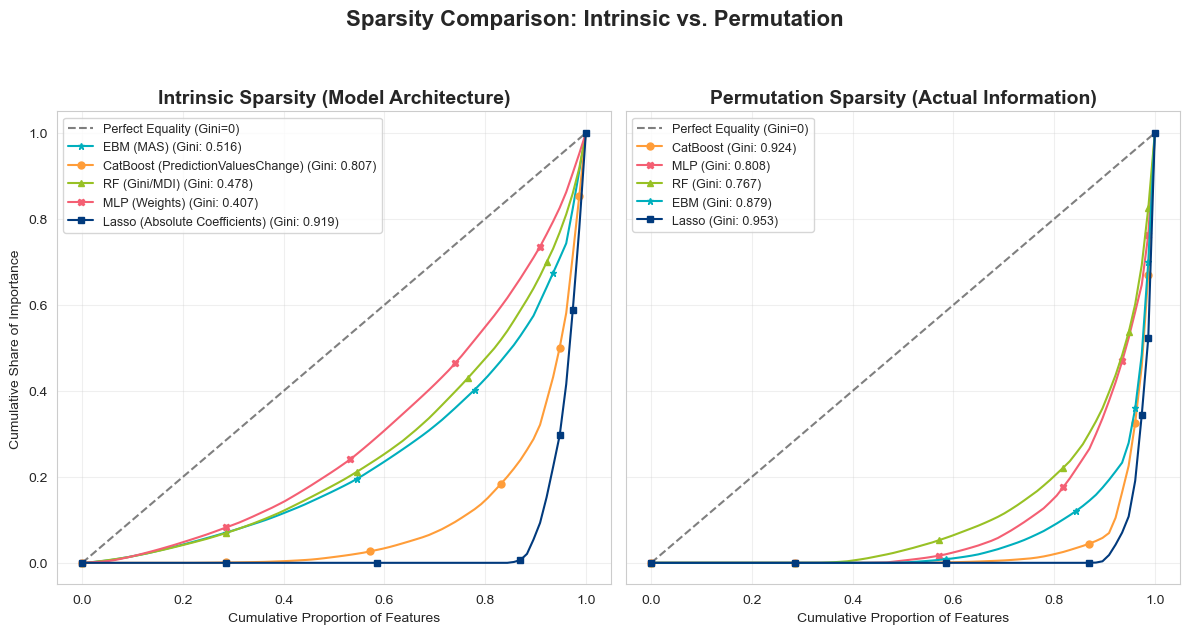

In [23]:
import matplotlib.pyplot as plt
import numpy as np


def plot_sparsity_side_by_side(intrinsic_results, permutation_results,
                               title="Sparsity Comparison: Intrinsic vs. Permutation", save_name=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    models = [model.split("(")[0].replace(" ", "") for model in permutation_results.keys()]
    print(models)
    palette, markers = get_model_style(models)

    # Hilfsfunktion für die Kurvenberechnung
    def add_lorenz_curve(ax, importance_dict, label_suffix=""):
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', alpha=0.5, label='Perfect Equality (Gini=0)')

        for name, values in importance_dict.items():
            # Werte säubern (Absolutbetrag & Nullen entfernen für saubere Kurve)
            clean_name = name.split("(")[0].replace(" ", "")
            clean_values = np.sort(np.abs(values))
            cum_imp = np.cumsum(clean_values) / np.sum(clean_values)

            x_axis = np.linspace(0, 1, len(cum_imp) + 1)
            cum_imp = np.insert(cum_imp, 0, 0)

            # Gini
            auc = np.trapz(cum_imp, x_axis)
            gini = (0.5 - auc) / 0.5

            ax.plot(x_axis, cum_imp, label=f"{name} (Gini: {gini:.3f})", linewidth=1.5, color=palette[clean_name],
                    marker=markers[clean_name], markevery=0.2, ms=5)

    # 1. Plot: Intrinsisch
    add_lorenz_curve(ax1, intrinsic_results)
    ax1.set_title("Intrinsic Sparsity (Model Architecture)", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Cumulative Share of Importance")
    ax1.set_xlabel("Cumulative Proportion of Features")
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(alpha=0.3)

    # 2. Plot: Permutation
    add_lorenz_curve(ax2, permutation_results)
    ax2.set_title("Permutation Sparsity (Actual Information)", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Cumulative Proportion of Features")
    ax2.legend(loc='upper left', fontsize=9)
    ax2.grid(alpha=0.3)

    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()

    if save_name:
        save_plot(fig, save_name, FIGURES_DIR)
    plt.show()


# Aufruf:
plot_sparsity_side_by_side(importance_data_intrinsic, importance_data_permutation, save_name="sparsity_sbs")